# Tweet Sentiment Analysis

This project uses Machine Learning models to classify tweets into a labelled sentiment using the Twitter Sentiment Analysis dataset from Kaggle (https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis?resource=download) which focuses on Entity-level sentiment analysis on multi-lingual tweets.


### Importing Libraries - Load Databases

First we import the libraries we will need in the project and check the dataset.

In [80]:
import pandas as pd
import numpy as np
import nltk
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from collections import defaultdict
import string
import itertools as it
import emoji
import re
import fileinput
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import load_model

%matplotlib inline

In [44]:
#Download resources
#pre-trained sentence tokenizer
nltk.download('punkt')
#list of stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bcancinomeyer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bcancinomeyer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bcancinomeyer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bcancinomeyer\AppData\Roaming\nltk_data...


True

In [45]:
twitter_training = pd.read_csv('twitter_training.csv', sep=',', names=['Tweet ID','Entity','Sentiment','Tweet_content'])
twitter_validation = pd.read_csv('twitter_validation.csv', sep=',', names=['Tweet ID','Entity','Sentiment','Tweet_content'])

In [46]:
twitter_training["Tweet ID"] = range(1, len(twitter_training) + 1)
twitter_validation["Tweet ID"] = range(1, len(twitter_validation) + 1)

## - Exploration of each dataset

In [47]:
twitter_training.head(3)

,Tweet ID,Entity,Sentiment,Tweet_content
0,1,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2,Borderlands,Positive,I am coming to the borders and I will kill you...
2,3,Borderlands,Positive,im getting on borderlands and i will kill you ...


In [48]:
twitter_validation.head(3)

,Tweet ID,Entity,Sentiment,Tweet_content
0,1,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,2,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,3,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...


In [49]:
# remove dupicate and nan values
twitter_training.dropna(inplace=True)
twitter_training.drop_duplicates(inplace=True)

In [50]:
twitter_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       73996 non-null  int64 
 1   Entity         73996 non-null  object
 2   Sentiment      73996 non-null  object
 3   Tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [51]:
twitter_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       1000 non-null   int64 
 1   Entity         1000 non-null   object
 2   Sentiment      1000 non-null   object
 3   Tweet_content  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


## - Finding Emojis in Dataframe

In [52]:
# Find emojis in whole dataframe training set

# Dictionary storing emoji counts 
emoji_training_count = defaultdict(int)
for i in twitter_training['Tweet_content']:
    for emoji in re.findall(u'[\U0001f300-\U0001f650]|[\u2000-\u3000]|[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|[\U0001F1E0-\U0001F1FF]|[\U00002702-\U000027B0]|[\U000024C2-\U0001F251]', i):
        emoji_training_count[emoji] += 1
    
# Find emojis in whole dataframe validation set

emoji_validation_count = defaultdict(int)
for i in twitter_validation['Tweet_content']:
    for emoji in re.findall(u'[\U0001f300-\U0001f650]|[\u2000-\u3000]|[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|[\U0001F1E0-\U0001F1FF]|[\U00002702-\U000027B0]|[\U000024C2-\U0001F251]', i):
        emoji_validation_count[emoji] += 1
    
print(emoji_training_count)
print(emoji_validation_count)
#- is there another way to find these emojis... what if we didn't find them all?

defaultdict(<class 'int'>, {'’': 9342, '‼': 27, '–': 213, '⃣': 55, '…': 3632, '•': 322, '′': 53, '“': 746, '”': 724, '‘': 231, '\u200d': 243, '—': 146, '″': 20, '→': 60, '₹': 5, '€': 30, '−': 7, '†': 12, '™': 34, '‡': 2, '🙂': 4, '⌚': 4, '‖': 8, '←': 1, '�': 9, '\u2060': 14, '„': 8, '）': 1, 'ℐ': 2, 'ℓ': 2, '√': 5, '■': 1, '\u2066': 37, '\u2069': 37, '，': 1, '。': 3, '≧': 2, '∇': 2, '≦': 2, '↑': 1, '\u200b': 9, '⁴': 1, '：': 2, '※': 2, '・': 1, '⏬': 2, '⇒': 3, '⇐': 1, '●': 1, '★': 1, '（': 1, '\u2063': 10, '⁄': 2, '₂': 2, '‚': 1, '⏳': 2})
defaultdict(<class 'int'>, {'’': 213, '‘': 9, '…': 140, '🙄': 1, '😆': 3, '🔥': 19, '😭': 18, '😍': 15, '😀': 1, '😳': 1, '👌': 1, '👏': 1, '😅': 5, '💛': 2, '☺': 3, '️': 41, '💙': 2, '🙌': 2, '“': 14, '”': 13, '💪': 5, '🏾': 6, '👍': 15, '🏆': 1, '😠': 1, '⚡': 1, '👀': 6, '🙏': 2, '❤': 15, '😒': 4, '🇳': 1, '🇬': 1, '💚': 7, '😩': 3, '👊': 3, '♥': 4, '😔': 3, '✊': 2, '–': 2, '\u200d': 9, '♂': 8, '😊': 2, '\u2066': 2, '\u2069': 2, '🌄': 1, '👇': 1, '💯': 2, '😡': 1, '☠': 6, '—': 5, '→': 2

In [53]:
#remove urls & special characters
def remove_urls(text):
    """Berilgan matndan URL larini o'chiradi"""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_emojis(text):
    """Berilgan matndan emojilarni o'chiradi"""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emojilar
                               u"\U0001F300-\U0001F5FF"  # simvollar va diagrammalar
                               u"\U0001F680-\U0001F6FF"  # transport va turli joylar
                               u"\U0001F1E0-\U0001F1FF"  # davlat bayroqlari
                               u"\U00002702-\U000027B0"  # dingbats
                               u"\U000024C2-\U0001F251"  # alamatchilik belgilari
                               u"\U0001f300-\U0001f650"  
                               u"\u2000-\u3000" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

twitter_training['Tweet_content'] = twitter_training['Tweet_content'].apply(lambda x: remove_emojis(x))
twitter_training['Tweet_content'] = twitter_training['Tweet_content'].apply(lambda x: remove_urls(x))

twitter_validation['Tweet_content'] = twitter_validation['Tweet_content'].apply(lambda x: remove_emojis(x))
twitter_validation['Tweet_content'] = twitter_validation['Tweet_content'].apply(lambda x: remove_urls(x))

## - Count information per category

In [54]:
#Replacing Irrelevant tweets to Neutral
for col in twitter_training:
    twitter_training.loc[twitter_training['Sentiment'] == 'Irrelevant', 'Sentiment'] = 'Neutral'

for col in twitter_validation:
    twitter_validation.loc[twitter_validation['Sentiment'] == 'Irrelevant', 'Sentiment'] = 'Neutral'
print(set(twitter_validation['Sentiment']))

{'Negative', 'Positive', 'Neutral'}


In [55]:
twitter_training['text_lens']=twitter_training['Tweet_content'].apply(lambda x: len(x))
twitter_validation['text_lens']=twitter_validation['Tweet_content'].apply(lambda x: len(x))

data_training_viz = twitter_training.groupby(by=["Entity","Sentiment"]).count().reset_index()
data_validation_viz = twitter_validation.groupby(by=["Entity","Sentiment"]).count().reset_index()

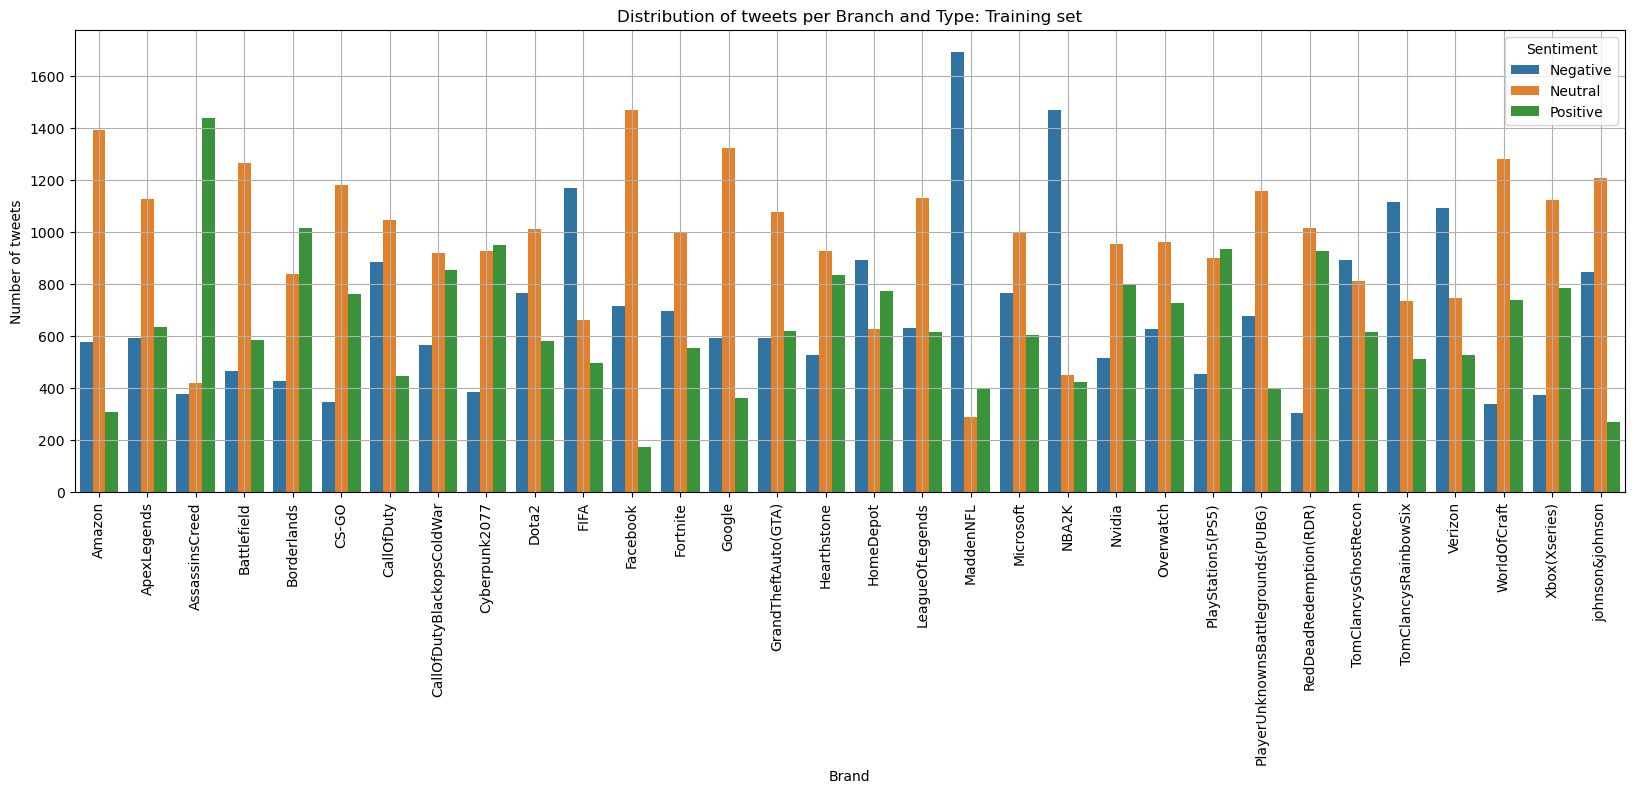

In [56]:
#Figure of comparison per branch
plt.figure(figsize=(20,6))
sns.barplot(data=data_training_viz,x="Entity", y="Tweet ID", hue='Sentiment')
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type: Training set")
plt.show()

## - Data Preprocessing

#### 1.- Entity Recognition

In [57]:
Entities_training = list(set(twitter_training['Entity']))
print(Entities_training)
#Entities_validation = list(set(twitter_validation['Entity']))
#print(Entities_validation)

['PlayStation5(PS5)', 'johnson&johnson', 'Nvidia', 'Dota2', 'Fortnite', 'ApexLegends', 'Google', 'CallOfDuty', 'TomClancysGhostRecon', 'Overwatch', 'Amazon', 'AssassinsCreed', 'MaddenNFL', 'TomClancysRainbowSix', 'Verizon', 'Hearthstone', 'NBA2K', 'LeagueOfLegends', 'PlayerUnknownsBattlegrounds(PUBG)', 'Cyberpunk2077', 'HomeDepot', 'Facebook', 'CallOfDutyBlackopsColdWar', 'FIFA', 'GrandTheftAuto(GTA)', 'Xbox(Xseries)', 'Battlefield', 'WorldOfCraft', 'Borderlands', 'RedDeadRedemption(RDR)', 'CS-GO', 'Microsoft']


In [58]:
#Creating our entity dictionary:
entity_dict = { 
                "RedDeadRedemption" : ['reddeadredemption', 'red dead redemption', 'red dead', 'rdr'], 
                "Microsoft": ['microsoft'],
                "Xbox":['xboxseriesx', 'xboxseriess', 'xboxone', 'xbox series x', 'xbox series s', 'xbox one', 'xseries', 'xbox'], 
                "AssassinsCreed": ['assassinscreed', 'assassins creed valhalla', 'assassins creed odyssey', 'assassins creed origins', 'assassins creed syndicate', 'assassins creed'], 
                "CallOfDutyBlackopsColdWar": ['callofdutyblackopscoldwar', 'codblackopscoldwar', 'blackopscoldwar', 'callofdutyblackops', 'codblackops', 'blackops', 'call of duty black ops cold war', 'cod black ops cold war', 'call of duty black ops', 'cod black ops', 'black ops cold war', 'black ops', 'cold war'],
                "FIFA": ['fifa22', 'fifa21', 'fifa20', 'fifa19', 'fifa18', 'fifa 22', 'fifa 21', 'fifa 20', 'fifa 19', 'fifa'],
                "TomClancysGhostRecon": ['tomclancysghostrecon', 'tomclancys', 'ghostrecon', 'tom clancys ghost recon', 'tom clancys', 'ghost recon'],
                "Google": ['google'],
                "PlayStation": ['playstation', 'storeplaystation','playstation store', 'ps5', 'ps4', 'ps3', 'PS'],
                "Facebook": ['facebook'],
                "GrandTheftAuto": ['grandtheftautov', 'grandtheftauto5', 'grandtheftauto', 'grand theft auto v', 'grand theft auto 5', 'grand theft auto', 'gtav', 'gta v' , 'gta'],
                "PlayerUnknownsBattlegrounds": ['playerunknownsbattlegrounds', 'player unknowns battlegrounds', 'pubg'],
                "Hearthstone": ['hearthstone'],
                "MaddenNFL": ['maddengame', 'madden'],
                "CallOfDuty": ['modernwarfare', 'callofduty', 'modern warfare' ,'call of duty', 'cod'],
                "Fortnite": ['fortnitegame', 'fortnite'],
                "Verizon": ['verizon'],
                "Nvidia": ['nvidia'],
                "Amazon": ['amazonplay', 'amazon', 'amazon play'],
                "WorldOfCraft": ['worldofwarcraft', 'world of warcraft', 'wow'],
                "ApexLegends": ['apexlegends', 'apex legends', 'apex'],
                "CS-GO": ['counterstrike', 'counter strike', 'csgo', 'cs go'],
                "johnson&johnson": ['johnson&johnson', 'johnson & johnson', 'johnsonjohnson'],
                "HomeDepot": ['homedepot', 'home depot'],
                "NBA2K": ['nba'],
                "Overwatch": ['overwatch'],
                "LeagueOfLegends": ['leagueoflegends', 'league of legends', 'lol'],
                "Borderlands": ['borderlands1', 'borderlands2', 'borderlands3', 'borderlans 1', 'borerlands 2', 'borderlands 3', 'borderlands'],
                "TomClancysRainbowSix": ['rainbowsixsiege', 'rainbowsix', 'rainbow six siege', 'rainbow six', 'rainbow'],
                "Dota": ['dota'],
                "Battlefield": ['battlefieldv', 'battlefield5', 'battlefield1', 'battlefield v', 'battlefield 5', 'battlefield 1', 'battlefield'],
                "Cyberpunk2077": ['cyberpunkgame', 'cyberpunk2077', 'cyberpunk'],
                "NintendoSwitch": ['nintendoswitch', 'nintendo switch', 'nintendo'],
                "Windows": ['windows', 'window']
              }

In [59]:
#Removing entities function
def remove_entities_list(text):
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)
    text = ' '.join([word for word in text.split()])
    text = text.lower()
    for entity_names in entity_dict:
        for game_names in entity_dict[entity_names]:
            if game_names.lower() in text:
                #print(game_names)
                text = text.replace(game_names, '')
                #print(text)
    text = ' '.join([word for word in text.split()])
    return text

In [60]:
#Entities Removed from Dataframes
twitter_training['Tweet_content'] = [remove_entities_list(word) for word in twitter_training['Tweet_content']]
twitter_validation['Tweet_content'] = [remove_entities_list(word) for word in twitter_validation['Tweet_content']]
print(twitter_training['Tweet_content'])
#print(twitter_validation['Tweet_content'])

0                  im getting on and i will murder you all
1        i am coming to the borders and i will kill you...
2                    im getting on and i will kill you all
3                   im coming on and i will murder you all
4             im getting on 2 and i will murder you me all
                               ...                        
74677    just realized that the partition of my mac is ...
74678    just realized that my mac partition is 6 years...
74679    just realized the partition of my mac is now 6...
74680    just realized between the partition of my mac ...
74681    just like the partition of my mac is like 6 ye...
Name: Tweet_content, Length: 73996, dtype: object


#### 2.-  Tokenization Process

In [65]:
#Tokenize every entry in data set
twitter_training['Tokenized Tweets'] = [word_tokenize(word) for word in twitter_training['Tweet_content']]
twitter_validation['Tokenized Tweets'] = [word_tokenize(word) for word in twitter_validation['Tweet_content']]
twitter_training.tail()

,Tweet ID,Entity,Sentiment,Tweet_content,text_lens,Tokenized Tweets
74677,74678,Nvidia,Positive,just realized that the partition of my mac is ...,128,"[just, realized, that, the, partition, of, my,..."
74678,74679,Nvidia,Positive,just realized that my mac partition is 6 years...,117,"[just, realized, that, my, mac, partition, is,..."
74679,74680,Nvidia,Positive,just realized the partition of my mac is now 6...,124,"[just, realized, the, partition, of, my, mac, ..."
74680,74681,Nvidia,Positive,just realized between the partition of my mac ...,158,"[just, realized, between, the, partition, of, ..."
74681,74682,Nvidia,Positive,just like the partition of my mac is like 6 ye...,118,"[just, like, the, partition, of, my, mac, is, ..."


In [66]:
# Removing stopwords, punctuation and numbers
#stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['....','...', '..', '’', "''", '``', '-', "'", "([a-zA-Z]+(?:'[a-z]+)?)"]
twitter_training['Tokenized Tweets'] = [word for word in twitter_training['Tokenized Tweets'] if word not in stopwords_list]
twitter_validation['Tokenized Tweets'] = [word for word in twitter_validation['Tokenized Tweets'] if word not in stopwords_list]
twitter_training.head()

,Tweet ID,Entity,Sentiment,Tweet_content,text_lens,Tokenized Tweets
0,1,Borderlands,Positive,im getting on and i will murder you all,53,"[im, getting, on, and, i, will, murder, you, all]"
1,2,Borderlands,Positive,i am coming to the borders and i will kill you...,51,"[i, am, coming, to, the, borders, and, i, will..."
2,3,Borderlands,Positive,im getting on and i will kill you all,50,"[im, getting, on, and, i, will, kill, you, all]"
3,4,Borderlands,Positive,im coming on and i will murder you all,51,"[im, coming, on, and, i, will, murder, you, all]"
4,5,Borderlands,Positive,im getting on 2 and i will murder you me all,57,"[im, getting, on, 2, and, i, will, murder, you..."


In [67]:
def listToString(s):
    str1 = " "
    return (str1.join(s))
     
twitter_training['Tokenized Tweets'] = [listToString(word) for word in twitter_training['Tokenized Tweets']]
twitter_validation['Tokenized Tweets'] = [listToString(word) for word in twitter_validation['Tokenized Tweets']]
twitter_training['Tokenized Tweets'][:5]

0              im getting on and i will murder you all
1    i am coming to the borders and i will kill you...
2                im getting on and i will kill you all
3               im coming on and i will murder you all
4         im getting on 2 and i will murder you me all
Name: Tokenized Tweets, dtype: object

#### 3.- Stemming & Lemmatization

In [64]:
lemmatizer = WordNetLemmatizer()

twitter_training['Tokenized Tweets'] = [lemmatizer.lemmatize(word) for word in twitter_training['Tokenized Tweets']]
twitter_validation['Tokenized Tweets'] = [lemmatizer.lemmatize(word) for word in twitter_validation['Tokenized Tweets']]
twitter_training['Tokenized Tweets'][:5]

0              im getting on and i will murder you all
1    i am coming to the borders and i will kill you...
2                im getting on and i will kill you all
3               im coming on and i will murder you all
4         im getting on 2 and i will murder you me all
Name: Tokenized Tweets, dtype: object

In [68]:
ps = PorterStemmer()

twitter_training['Tokenized Tweets'] = [ps.stem(word) for word in twitter_training['Tokenized Tweets']]
twitter_validation['Tokenized Tweets'] = [ps.stem(word) for word in twitter_validation['Tokenized Tweets']]
twitter_training['Tokenized Tweets'][:5]

0               im getting on and i will murder you al
1    i am coming to the borders and i will kill you al
2                 im getting on and i will kill you al
3                im coming on and i will murder you al
4          im getting on 2 and i will murder you me al
Name: Tokenized Tweets, dtype: object

#### 3.- Train/Test Splits

In [69]:
from sklearn.model_selection import train_test_split
X_train ,X_test , y_train, y_test = train_test_split(twitter_training[['Tokenized Tweets']], twitter_training[['Sentiment']], test_size=0.2, random_state=42)

In [70]:
# Vectorization usinf TF-IDF
vectorizer= TfidfVectorizer()

X_train_vect= vectorizer.fit_transform(X_train['Tokenized Tweets'])
X_test_vect= vectorizer.transform(X_test['Tokenized Tweets'])

y_train=y_train['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2})
y_test=y_test['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2})

In [71]:
validation_X = vectorizer.transform(twitter_validation['Tokenized Tweets'])
validation_y = twitter_validation['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2})

## - Machine Learning Models

#### 1.- Multi-Class Logistical Regression

In [72]:
# Define the multinomial logistic regression model afterd data is cleaned using Lemmatization and Stemming
mcLR = LogisticRegression(multi_class='multinomial', solver='lbfgs')
mcLR.fit(X_train_vect,y_train)
y_predict_mcLR = mcLR.predict(X_test_vect)

unique_classes = twitter_training['Sentiment'].unique()
# Print classification report (includes precision, recall, F1-score, etc.)
print("\nClassification Report:\n")
print(classification_report(y_test, y_predict_mcLR, target_names=unique_classes))


Classification Report:

              precision    recall  f1-score   support

    Positive       0.81      0.75      0.78      4119
     Neutral       0.82      0.79      0.81      4380
    Negative       0.79      0.84      0.81      6301

    accuracy                           0.80     14800
   macro avg       0.81      0.80      0.80     14800
weighted avg       0.80      0.80      0.80     14800



C:\Users\bcancinomeyer\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 2.- DecisionTreeClassifier

In [73]:
clf = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train_vect, y_train)

y_pred_clf = clf.predict(X_test_vect)

unique_classes = twitter_training['Sentiment'].unique()
# Print classification report (includes precision, recall, F1-score, etc.)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_clf, target_names=unique_classes))


Classification Report:

              precision    recall  f1-score   support

    Positive       0.71      0.73      0.72      4119
     Neutral       0.76      0.76      0.76      4380
    Negative       0.77      0.76      0.77      6301

    accuracy                           0.75     14800
   macro avg       0.75      0.75      0.75     14800
weighted avg       0.75      0.75      0.75     14800



#### 3.- Neural Network

In [82]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(twitter_training['Tokenized Tweets'])
sequences = tokenizer.texts_to_sequences(twitter_training['Tokenized Tweets'])
X = pad_sequences(sequences)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(twitter_training['Sentiment'])

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = X.shape[1]
embedding_dim = 100
lstm_units = 128

In [85]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

In [86]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
y_train_encoded = np.eye(len(label_encoder.classes_))[y_train]
y_test_encoded = np.eye(len(label_encoder.classes_))[y_test]

In [87]:
loaded_model = load_model("tweetsentiment_lstm_model.h5")

OSError: No file or directory found at tweetsentiment_lstm_model.h5

*The following chunk of code will be commented so as to avoid training the model every time the notebook is run. Instead, the line above loading the model should be run.

In [ ]:
# batch_size = 64
# epochs = 10
# model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.2)}
# model.save('tweetsentiment_lstm_model.h5')

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

In [ ]:
new_sequences = tokenizer.texts_to_sequences(valid_df["Tweet Content"])
new_X = pad_sequences(new_sequences, maxlen=max_sequence_length)
class_predictions = loaded_model.predict(new_X)
predicted_labels = np.argmax(predictions, axis=1)

#### 4.- Validation Test

In [ ]:
y_predict_validation = mcLR.predict(validation_X)

unique_classes = twitter_training['Sentiment'].unique()
print(classification_report(validation_y, y_predict_validation, target_names=unique_classes))

#### - Confusion Matrix

In [ ]:
# Print Confusion Matrix: Multi-Class Logistical Regression

cnf_matrix = confusion_matrix(y_test, y_predict_mcLR)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot(cmap=plt.cm.Oranges)

In [ ]:
# Print Confusion Matrix: DecisionTreeClassifier

cnf_matrix = confusion_matrix(y_test, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot(cmap=plt.cm.Oranges)

### Visualizing the model results and precision
*The following chunk of code in this cell was provided as help to us by our incredible Nick McCarty to help overcome the
blocker of the ML model not working*

In [ ]:
# Assuming valid_df["Sentiment"] contains string labels like "positive", "negative", "neutral"
label_mapping = {0: "positive", 1: "negative", 2: "neutral"}

# Convert class_predictions to string labels
predicted_labels_str = [label_mapping[pred] for pred in predicted_labels]

# Get the actual labels as string from valid_df["Sentiment"]
actual_labels_str = valid_df["Sentiment"]

# Create confusion matrix
cm = confusion_matrix(actual_labels_str, predicted_labels_str)[:3, 3:]

# Create a figure and axis
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

#### Testing if model predicts if comment is Positive, Negative, Neutral

In [ ]:
twitter_training.iloc[346]

In [ ]:
text0= 'I hate this game'
text1 ='with guns metal and tentacles 10 enunk secret weapons ranked'
text2 = 'I love this game is my favorite'
test=twitter_training['Tweet_content'][346]
text_final = vectorizer.transform([test])

predict = mcLR.predict(text_final)

In [ ]:
vector={0:"Positive",1:"Negative",2:"Neutral"}
sentiment=vector[list(predict)[0]]
print(f'{list(predict)[0]},  {sentiment}')